In [1]:
#import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
from prophet.plot import plot_plotly,plot_components_plotly

import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load data
#df=pd.read_csv(r'..\Forage\Nat_Gas.csv')
df=pd.read_csv(r'C:\Users\USER\Guvi python\Forage\Nat_Gas.csv')

#Initial inspection
print(df.info())
print(df.describe())
print(df.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes
None
          Prices
count  48.000000
mean   11.207083
std     0.757897
min     9.840000
25%    10.650000
50%    11.300000
75%    11.625000
max    12.800000
      Dates  Prices
0  10/31/20   10.10
1  11/30/20   10.30
2  12/31/20   11.00
3   1/31/21   10.90
4   2/28/21   10.90
5   3/31/21   10.90
6   4/30/21   10.40
7   5/31/21    9.84
8   6/30/21   10.00
9   7/31/21   10.10


In [3]:
#Format it into datetime format
df['Dates']=df['Dates'].str.replace('/','-')
df['Dates'] = pd.to_datetime(df['Dates'],format='%m-%d-%y')


In [4]:
df.head(10)

,Dates,Prices
0,2020-10-31,10.10
1,2020-11-30,10.30
2,2020-12-31,11.00
3,2021-01-31,10.90
4,2021-02-28,10.90
5,2021-03-31,10.90
6,2021-04-30,10.40
7,2021-05-31,9.84
8,2021-06-30,10.00
9,2021-07-31,10.10


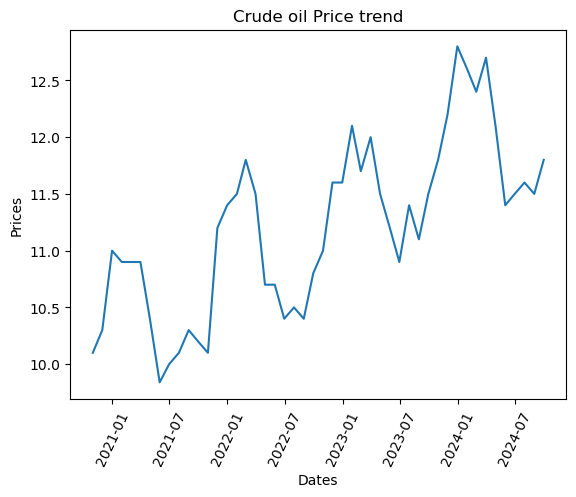

In [5]:
#Visualization
sns.lineplot(df,x=df['Dates'],y=df['Prices'])

plt.title('Crude oil Price trend')
plt.xticks(rotation=65)
plt.show()


***ARIMA***

In [6]:
#Check for stationarity
result = adfuller(df['Prices'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print('Stationary' if result[1] < 0.05 else 'Non-Stationary')

ADF Statistic: 0.21807686170000262
p-value: 0.9732574388448695
Non-Stationary


In [7]:

# Apply first-order differencing
result_df=df
result_df['Prices_Diff'] = result_df['Prices'].diff()

# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(result_df["Prices_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")

ADF Statistic (Differenced): -6.8448
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


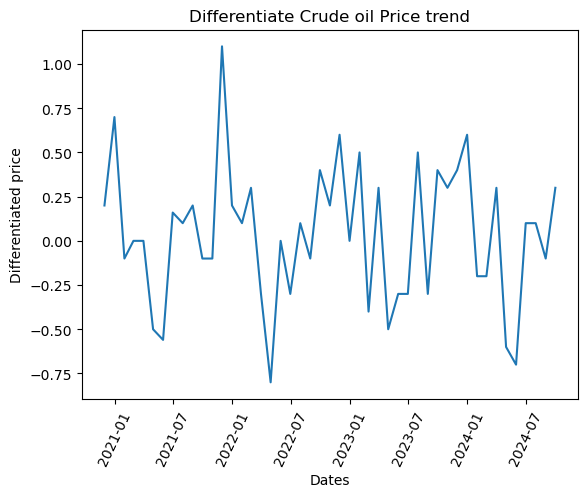

In [8]:
sns.lineplot(result_df,x=result_df['Dates'],y=result_df['Prices_Diff'])

plt.title('Differentiate Crude oil Price trend')
plt.xticks(rotation=65)
plt.ylabel("Differentiated price")
plt.show()

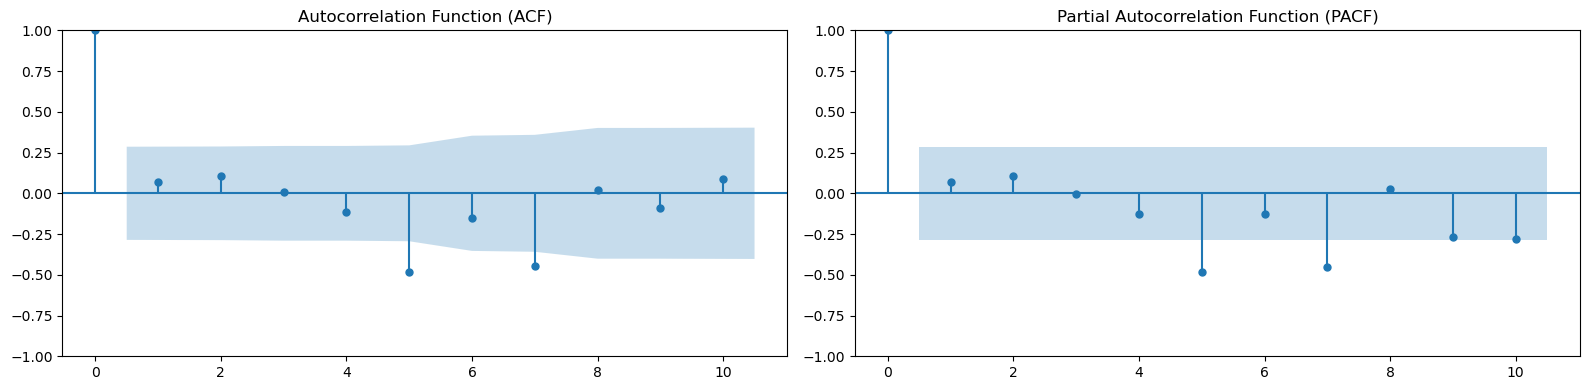

In [9]:
# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(result_df['Prices_Diff'] .dropna(), lags=10, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(result_df['Prices_Diff'] .dropna(), lags=10, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [10]:
#Determine the hyperparameters
stepwise_fit=auto_arima(result_df['Prices_Diff'] .dropna(),start_p=0, start_q=0, 
                        max_p=20,
                           max_q=20, 
                        m=1,scoring='mae',stationary=False,stepwise=False,trace=True)
stepwise_fit.summary

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=48.334, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=50.139, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=51.528, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=52.181, Time=0.18 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=50.098, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=51.953, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=53.197, Time=0.17 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=54.043, Time=0.17 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=51.566, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=53.566, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=36.060, Time=0.44 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=53.674, Time=0.32 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=53.565,

<bound method ARIMA.summary of ARIMA(order=(2, 0, 2), scoring='mae', scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)>

In [11]:
result_df=result_df.dropna()

In [12]:
#Train,test split
train_size=int(0.8*len(result_df))
train=result_df.iloc[:train_size]
test=result_df.iloc[train_size:]


                               SARIMAX Results                                
Dep. Variable:            Prices_Diff   No. Observations:                   37
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 -15.261
Date:                Mon, 28 Apr 2025   AIC                             42.522
Time:                        14:40:09   BIC                             52.188
Sample:                             0   HQIC                            45.930
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0591      0.083      0.711      0.477      -0.104       0.222
ar.L1          0.2167      0.264      0.821      0.411      -0.300       0.734
ar.L2         -0.6705      0.297     -2.258      0.0

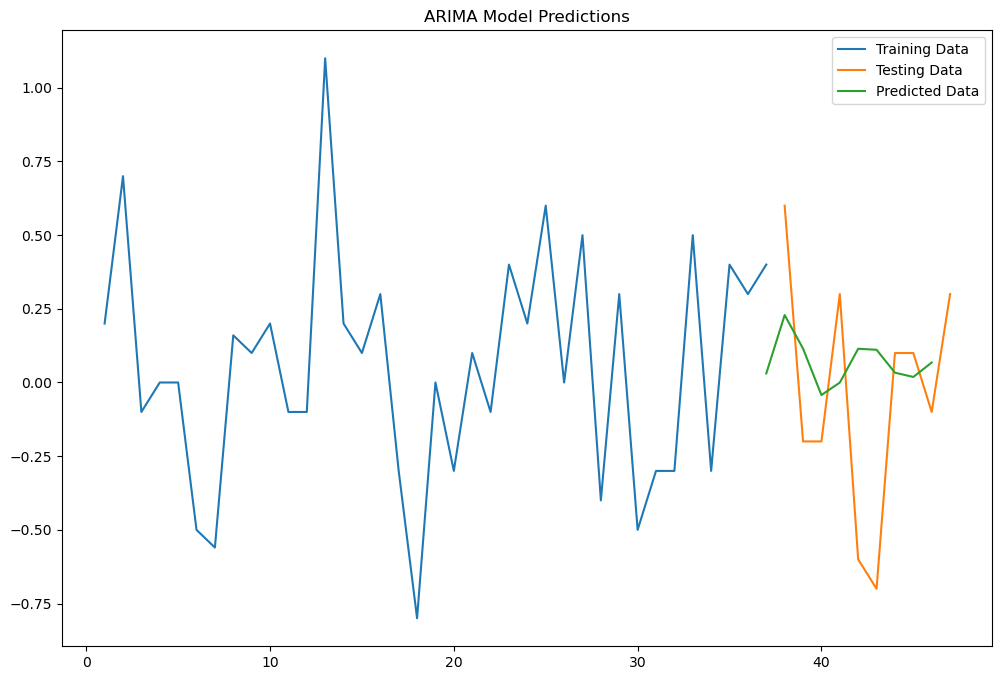

MAPE: 1.0711544027367979


In [13]:
model=ARIMA(train['Prices_Diff'],order=(2,0,2))
arima_model = model.fit()
print(arima_model.summary())

arima_pred=arima_model.predict(start=train_size,end=len(result_df)-1,typ='levels')
print(arima_pred)

plt.figure(figsize=(12,8))
plt.plot(train['Prices_Diff'], label='Training Data')
plt.plot(test['Prices_Diff'], label='Testing Data')
plt.plot(arima_pred, label='Predicted Data')
plt.legend()
plt.title('ARIMA Model Predictions')
plt.show()


#Metrics dictionary to compare all the model performance

mape = mean_absolute_percentage_error(np.array(test['Prices_Diff']), np.array(arima_pred))
print(f"MAPE: {mape}")

***SARIMA***

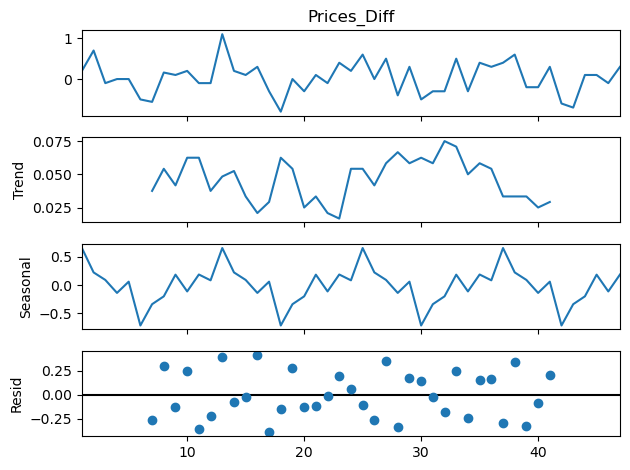

In [14]:
# Assuming `quantity_sales_by_date` is set with 'order_date' as index
result = seasonal_decompose(result_df['Prices_Diff'] , model='additive', period=12)

# Plot the decomposition
result.plot()
plt.show()

In [15]:
## Determine the hyperparameters
stepwise_fit=auto_arima(result_df['Prices_Diff'] , seasonal=True, m=12, stepwise=True, trace=True)
stepwise_fit.summary

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=36.941, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=48.334, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=38.394, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=42.336, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=46.741, Time=0.04 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=39.471, Time=1.41 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=38.669, Time=1.04 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=36.060, Time=0.37 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=53.197, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=53.566, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=53.701, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=53.674, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=51.953, Ti

<bound method ARIMA.summary of ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)>

                               SARIMAX Results                                
Dep. Variable:            Prices_Diff   No. Observations:                   37
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 -15.949
Date:                Mon, 28 Apr 2025   AIC                             41.898
Time:                        14:40:19   BIC                             49.953
Sample:                             0   HQIC                            44.738
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5246      0.496      1.058      0.290      -0.448       1.497
ar.L2         -0.5522      0.536     -1.029      0.303      -1.603       0.499
ma.L1         -0.5130      0.380     -1.351      0.1

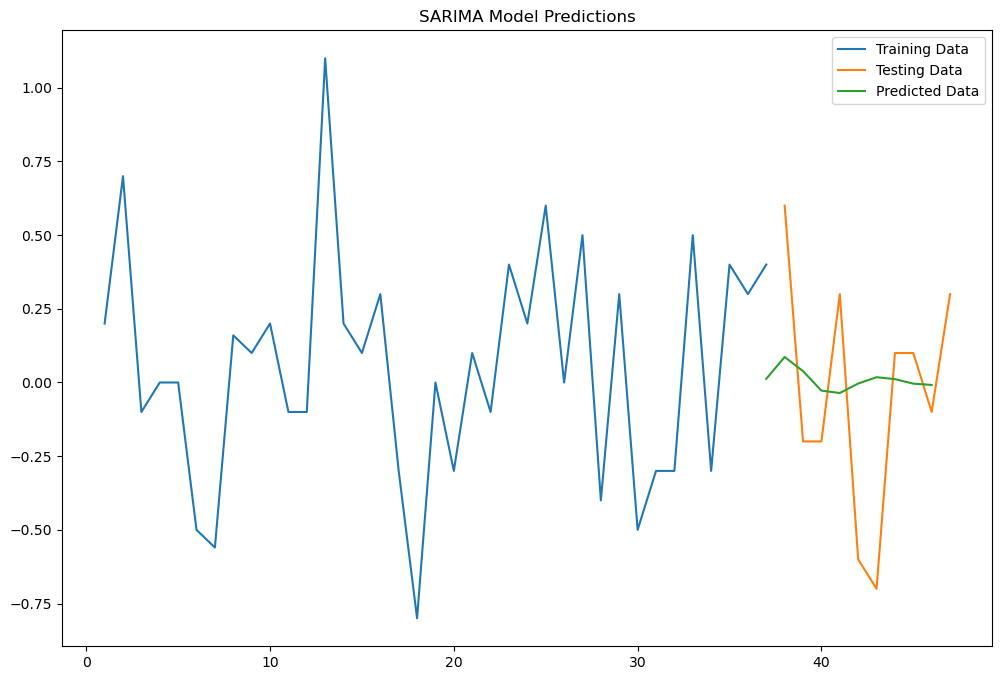

MAPE: 1.0328022286803633


In [16]:
model = SARIMAX(train['Prices_Diff'], 
                       order=(2, 0, 2),  # AR, differencing, MA order (p, d, q)
                       seasonal_order=(0, 0, 0, 12))  # Seasonal AR, differencing, MA order (P, D, Q, m)
sarima_model = model.fit()
print(sarima_model.summary())

sarima_pred=sarima_model.predict(start=train_size,end=len(result_df)-1,typ='levels')
print(sarima_pred)

plt.figure(figsize=(12,8))
plt.plot(train['Prices_Diff'], label='Training Data')
plt.plot(test['Prices_Diff'], label='Testing Data')
plt.plot(sarima_pred, label='Predicted Data')
plt.legend()
plt.title('SARIMA Model Predictions')
plt.show()


mape = mean_absolute_percentage_error(np.array(test['Prices_Diff']), np.array(sarima_pred))
print(f"MAPE: {mape}")


***Prophet***

14:40:20 - cmdstanpy - INFO - Chain [1] start processing
14:40:21 - cmdstanpy - INFO - Chain [1] done processing


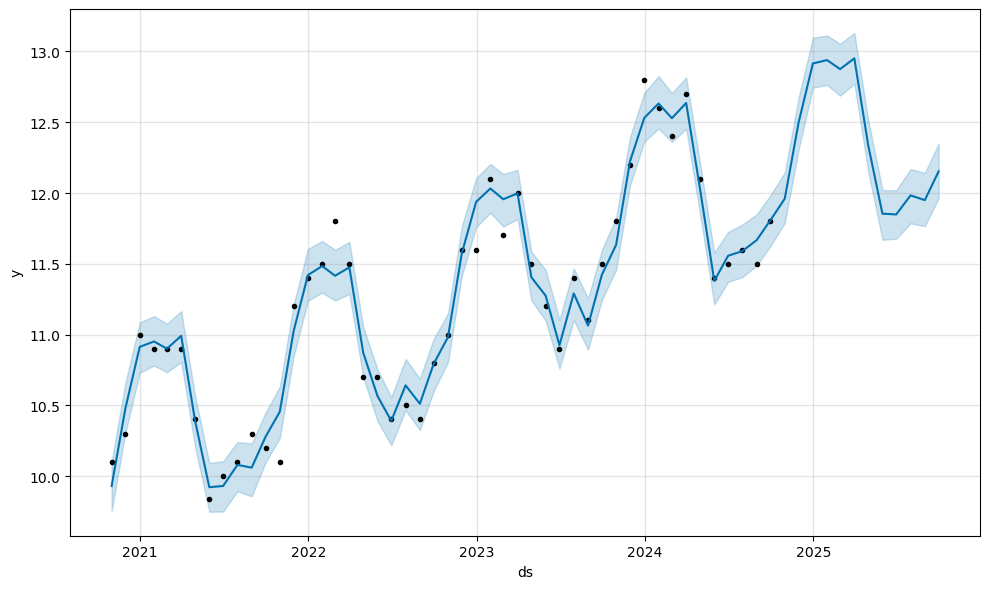

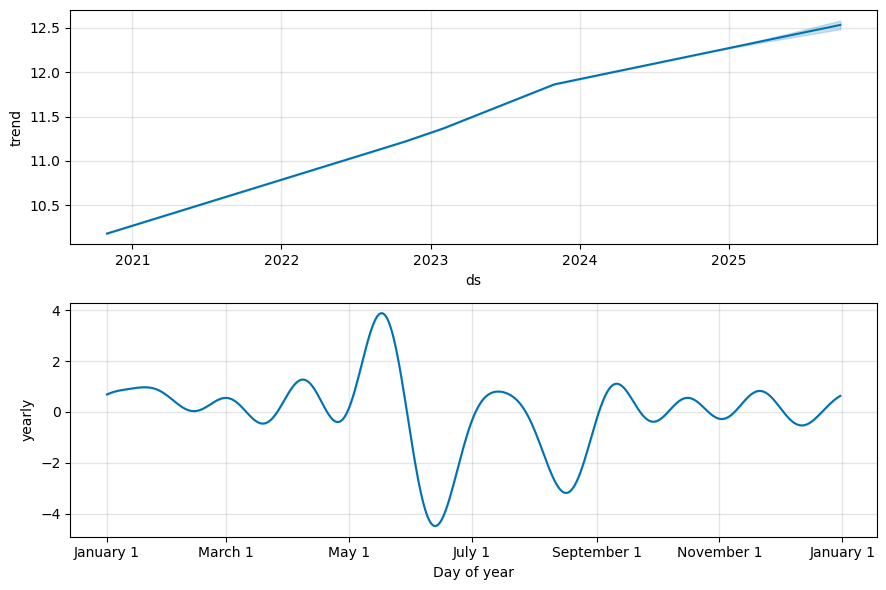

MAPE: 0.008929306705689219


In [17]:
prophet_df=df.drop(columns=['Prices_Diff'])
prophet_df.columns=['ds','y']
prophet_model=Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=12,freq='M')
prophet_pred=prophet_model.predict(future)
prophet_model.plot(prophet_pred)
prophet_model.plot_components(prophet_pred)

plt.show()


# merged_data = pd.merge(test_p[['ds', 'y']], prophet_pred[['ds', 'yhat']], on='ds', how='inner')
# merged_data = merged_data.dropna(subset=['y', 'yhat'])
mape=mean_absolute_percentage_error(np.array(prophet_df['y'].values), np.array(prophet_pred['yhat'][:len(prophet_df)].values))
print(f"MAPE: {mape}")




#Prophet model is more accurate.Hence picking prophet model for prediction purpose

In [18]:
specific_date = pd.to_datetime(input("Enter a past date (YYYY-MM-DD):"))
pred = prophet_model.predict(pd.DataFrame({'ds': [specific_date]}))
print(f"Predicted value on {specific_date.date()}: {round(pred['yhat'].values[0], 4)}")

Enter a past date (YYYY-MM-DD): 2025-05-31


Predicted value on 2025-05-31: 11.8538


In [19]:
x=prophet_pred.iloc[len(df):][['ds','yhat']]
x.reset_index(drop=True, inplace=True)
x.columns=['Date','Prices']
print(f"Forecasted price for the following one year : ")
print(x)

Forecasted price for the following one year : 
         Date     Prices
0  2024-10-31  11.960253
1  2024-11-30  12.497222
2  2024-12-31  12.915387
3  2025-01-31  12.939215
4  2025-02-28  12.875286
5  2025-03-31  12.951613
6  2025-04-30  12.339306
7  2025-05-31  11.853801
8  2025-06-30  11.848579
9  2025-07-31  11.983327
10 2025-08-31  11.949657
11 2025-09-30  12.153211


In [20]:
#saving the model as pickle file
import pickle

with open('CrudeOilPricing.pkl','wb') as file:
    pickle.dump(prophet_model,file)

In [23]:
# Load the pre-trained model from a pickle file
with open('CrudeOilPricing.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [24]:
print(loaded_model)